# This notebook implements Deep learning techniques for a particle-in-halo classification framework. 


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pandas as pd

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses

%matplotlib inline

# workdirectory = '/home/jazhiel/ML_Notebooks/Cosmology_ML/'
workdirectory = 'data/'

In [2]:
import time
import sys

In [3]:
sys.path.append("/home/isidro/Documents/github/nnogada/")
from nnogada.Nnogada import Nnogada

## Import our dataset 

In [4]:
data_dict = np.load(workdirectory+'OUTFILE1M.npz')
test_flags  = data_dict['test_flags'] ## not important
test_hosts  = data_dict['test_hosts'] ### somewhat relevant
test_mass   = data_dict['test_mass'] ## important
test_labels = data_dict['test_labels'] ## important
test_input  = data_dict['test_input'] ## very important
#test_snid   = dict_data['test_snid']
#test_labels = dict_data['test_labels']
print(test_mass) ## Here I want to check how is the halo mass matrix composed of, the -1 means the halo 
#is not in our range of 10^12-10^13 M_sun
print(np.sum(test_labels)) ## Here I want to check how many label "1" do we have

[-1.00000000e+00  2.72242898e+13  1.13894322e+13 ... -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00]
289964


## Data preprocessing

In [5]:
### here we create or 10 vector dataset, I wonder if by adding some other information the classification will be better
### adding mass is not helpful, the classifier is perfect in that regard
dr1 = pd.DataFrame(test_input[0], columns = ['dr1'])
dr2 = pd.DataFrame(test_input[1], columns = ['dr2'])
dr3 = pd.DataFrame(test_input[2], columns = ['dr3'])
dr4 = pd.DataFrame(test_input[3], columns = ['dr4'])
dr5 = pd.DataFrame(test_input[4], columns = ['dr5'])
dr6 = pd.DataFrame(test_input[5], columns = ['dr6'])
dr7 = pd.DataFrame(test_input[6], columns = ['dr7'])
dr8 = pd.DataFrame(test_input[7], columns = ['dr8'])
dr9 = pd.DataFrame(test_input[8], columns = ['dr9'])
dr10 = pd.DataFrame(test_input[9], columns = ['dr10'])
#mass = pd.DataFrame(test_mass, columns = ['Halo_Mass'])
lbl = pd.DataFrame(test_labels, columns =['labels'])

## Select all features and create dataframe

In [6]:
df = pd.concat([dr1, dr2, dr3, dr4, dr5, dr6, dr7, dr8, dr9, dr10, lbl], axis=1, ignore_index=False, sort=False)
df

,dr1,dr2,dr3,dr4,dr5,dr6,dr7,dr8,dr9,dr10,labels
0,-0.209889,-0.187730,-0.169542,-0.155964,-0.100744,-0.049741,-0.011099,-0.010984,-0.002834,0.024089,0
1,0.364046,0.430008,0.453121,0.450021,0.374578,0.309706,0.240559,0.190503,0.174401,0.176335,1
2,0.311775,0.254511,0.227109,0.215286,0.148460,0.112097,0.090454,0.058546,0.035873,0.043613,1
3,0.033877,0.051836,0.065151,0.073930,0.100935,0.100271,0.094132,0.080007,0.059981,0.032160,0
4,-0.355428,-0.330448,-0.306125,-0.291701,-0.253399,-0.215256,-0.163749,-0.124680,-0.080408,-0.051999,0
...,...,...,...,...,...,...,...,...,...,...,...
999995,0.022223,0.034349,0.046298,0.047812,0.027945,0.018082,0.012005,0.015623,0.028762,0.036779,0
999996,-0.178963,-0.188312,-0.189045,-0.187326,-0.182576,-0.170714,-0.155041,-0.143078,-0.136640,-0.120222,0
999997,-0.164632,-0.113120,-0.076089,-0.061724,0.009549,0.039809,0.057906,0.041327,0.010610,-0.020231,0
999998,-0.039698,0.063765,0.118363,0.140928,0.152761,0.125845,0.114529,0.113929,0.107155,0.098008,0


## Here we select a dataframe consisting of evenly separated labels

(I'm not sure if selecting all particles will impact in a different result)


In [7]:
## Sorting out the labels consisting in label '0' and label '1'
## Then we sample them in order to not selecting them in a specific range or shape

df_0 = df.sort_values('labels').head(710036).sample(289000)
df_1 = df.sort_values('labels').tail(289964).sample(289000) 
df_1.labels.sum()
df_r = pd.concat([df_0, df_1])


randomize = np.random.permutation(len(df_r.values))
data = df_r.values[randomize]

## define a size for our traning dataset 

I think that for 500k + particles we can divide into train, test and validation datasets

In [8]:
# Define a size for your train set 
split = 0.8
ntrain = int(split * len(data))
indx = [ntrain]
train_set, test_set = np.split(data, indx)

split = 0.5
ntrain = int(split * len(test_set))
indx = [ntrain]
validation_set, test_test = np.split(test_set, indx)

## Select data, X for attributes, y for labels

In [9]:
X_train = train_set[:, :-1]
y_train = train_set[:, -1]

X_val = validation_set[:, :-1]
y_val = validation_set[:, -1]

X_test = test_set[:, :-1]
y_test = test_set[:, -1]

In [10]:
np.shape(X_train), np.shape(X_val), np.shape(X_test), np.shape(y_train), np.shape(y_val), np.shape(y_test)

((462400, 10), (57800, 10), (115600, 10), (462400,), (57800,), (115600,))

In [11]:
y_val = y_val.reshape(-1,1)
np.shape(y_val)

(57800, 1)

In [12]:
y_train = y_train.reshape(-1,1)
np.shape(y_train)

(462400, 1)

# Searching hyperparameters with genetic algorithms

In [13]:
population_size = 10  # max of individuals per generation
max_generations = 10   # number of generations
gene_length = 4        # lenght of the gene, depends on how many hiperparameters are tested
k = 1                  # num. of finalist individuals

t = time.time()
datos = []T

# Define the hyperparameters for the search
hyperparams = {'deep': [3, 4], 'num_units': [100, 200], 'batch_size': [512, 1024]}

# generate a Nnogada instance
net_fit = Nnogada(hyp_to_find=hyperparams, X_train=X_train, Y_train=y_train, X_val=X_val, Y_val=y_val, regression=True)
# Set the possible values of hyperparameters and not use the default values from hyperparameters.py
net_fit.set_hyperparameters()

# best solution
best_population = net_fit.ga_with_elitism(population_size, max_generations, gene_length, k)
print(best_population)
print("Total elapsed time:", (time.time()-t)/60, "minutes")

100%|██████████| 10/10 [7:01:01<00:00, 2142.89s/it] 


Best 5 solutions:
-----------------

   deep  num_units  batch_size      loss     score        time
0     4        100         512  0.148364  0.148364  298.439124
1     4        100         512  0.148368  0.148368  301.917318
2     4        100         512  0.148381  0.148381  301.315263
3     4        100         512  0.148392  0.148392  303.483416
4     4        200         512  0.148405  0.148405  501.007462
[[1, 0, 0, 0]]
Total elapsed time: 457.0988372564316 minutes


In [40]:
net_fit.history.sort_values(by='score')

,deep,num_units,batch_size,loss,score,time
0,4,100,512,0.148364,0.148364,298.439124
1,4,100,512,0.148368,0.148368,301.917318
2,4,100,512,0.148381,0.148381,301.315263
3,4,100,512,0.148392,0.148392,303.483416
4,4,200,512,0.148405,0.148405,501.007462
...,...,...,...,...,...,...
70,3,100,1024,0.148944,0.148944,158.335883
71,3,100,1024,0.149008,0.149008,205.829587
72,4,100,512,0.149088,0.149088,306.203994
73,4,200,512,0.149139,0.149139,500.385237


## For the Confusion matrix 


In [14]:
#### THIS CELL IS FOR CALCULATE THE CONFUSION MATRIX ####
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

## Perceptron with Keras

In [41]:
#para scikit-learn: (samples,features)
#test_input_T = test_input.T
#X_train, X_test, y_train, y_test = train_test_split(test_input_T,test_labels,test_size=0.25,random_state=None)

#ANN
test1_model = models.Sequential()
test1_model.add(layers.Dense(100,activation='tanh',input_shape=(10,)))
test1_model.add(layers.Dense(100,activation='tanh'))
test1_model.add(layers.Dense(100,activation='tanh'))
test1_model.add(layers.Dense(100,activation='tanh'))
#test1_model.add(layers.Dense(10,activation='relu'))
test1_model.add(layers.Dense(1, activation='sigmoid'))

test1_model.compile(optimizer=optimizers.Adam(lr=0.001),#RMSprop(lr=0.001),
                    loss=losses.mean_squared_error,
                    metrics=['accuracy'])


test1_model.summary()

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_462 (Dense)           (None, 100)               1100      
                                                                 
 dense_463 (Dense)           (None, 100)               10100     
                                                                 
 dense_464 (Dense)           (None, 100)               10100     
                                                                 
 dense_465 (Dense)           (None, 100)               10100     
                                                                 
 dense_466 (Dense)           (None, 1)                 101       
                                                                 
Total params: 31,501
Trainable params: 31,501
Non-trainable params: 0
_________________________________________________________________


In [42]:
# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=200, restore_best_weights=True)]
test1_model_history = test1_model.fit(X_train,
                                      y_train,
                                      epochs=500,
                                      batch_size=512,
                                      validation_data=(X_val,y_val),
                                      verbose=1)

Epoch 1/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1551 - accuracy: 0.7759 - val_loss: 0.1505 - val_accuracy: 0.7822
Epoch 2/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1511 - accuracy: 0.7814 - val_loss: 0.1495 - val_accuracy: 0.7834
Epoch 3/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1510 - accuracy: 0.7816 - val_loss: 0.1499 - val_accuracy: 0.7835
Epoch 4/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1509 - accuracy: 0.7814 - val_loss: 0.1495 - val_accuracy: 0.7832
Epoch 5/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1507 - accuracy: 0.7818 - val_loss: 0.1495 - val_accuracy: 0.7839
Epoch 6/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1508 - accuracy: 0.7820 - val_loss: 0.1497 - val_accuracy: 0.7817
Epoch 7/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1506 - accuracy: 0.7820 - val_loss: 0.1493 - val_accuracy: 0.7836

Epoch 58/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1478 - accuracy: 0.7864 - val_loss: 0.1476 - val_accuracy: 0.7875
Epoch 59/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1476 - accuracy: 0.7868 - val_loss: 0.1478 - val_accuracy: 0.7855
Epoch 60/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1476 - accuracy: 0.7869 - val_loss: 0.1478 - val_accuracy: 0.7862
Epoch 61/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1475 - accuracy: 0.7870 - val_loss: 0.1476 - val_accuracy: 0.7855
Epoch 62/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1474 - accuracy: 0.7873 - val_loss: 0.1474 - val_accuracy: 0.7864
Epoch 63/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1473 - accuracy: 0.7873 - val_loss: 0.1481 - val_accuracy: 0.7855
Epoch 64/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1472 - accuracy: 0.7873 - val_loss: 0.1474 - val_accuracy:

Epoch 115/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1412 - accuracy: 0.7992 - val_loss: 0.1457 - val_accuracy: 0.7916
Epoch 116/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1411 - accuracy: 0.7989 - val_loss: 0.1455 - val_accuracy: 0.7903
Epoch 117/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1408 - accuracy: 0.7997 - val_loss: 0.1457 - val_accuracy: 0.7919
Epoch 118/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1407 - accuracy: 0.8000 - val_loss: 0.1452 - val_accuracy: 0.7914
Epoch 119/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1405 - accuracy: 0.8001 - val_loss: 0.1453 - val_accuracy: 0.7925
Epoch 120/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1403 - accuracy: 0.8006 - val_loss: 0.1455 - val_accuracy: 0.7923
Epoch 121/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1402 - accuracy: 0.8006 - val_loss: 0.1454 - val_ac

904/904 [==============================] - 3s 4ms/step - loss: 0.1317 - accuracy: 0.8173 - val_loss: 0.1437 - val_accuracy: 0.7982
Epoch 172/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1315 - accuracy: 0.8177 - val_loss: 0.1434 - val_accuracy: 0.7986
Epoch 173/500
904/904 [==============================] - 4s 5ms/step - loss: 0.1313 - accuracy: 0.8183 - val_loss: 0.1428 - val_accuracy: 0.7999
Epoch 174/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1311 - accuracy: 0.8186 - val_loss: 0.1435 - val_accuracy: 0.7993
Epoch 175/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1312 - accuracy: 0.8185 - val_loss: 0.1435 - val_accuracy: 0.7994
Epoch 176/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1309 - accuracy: 0.8187 - val_loss: 0.1430 - val_accuracy: 0.7998
Epoch 177/500
904/904 [==============================] - 4s 4ms/step - loss: 0.1308 - accuracy: 0.8187 - val_loss: 0.1436 - val_accuracy: 0.7989

904/904 [==============================] - 3s 4ms/step - loss: 0.1239 - accuracy: 0.8321 - val_loss: 0.1421 - val_accuracy: 0.8044
Epoch 228/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1237 - accuracy: 0.8322 - val_loss: 0.1422 - val_accuracy: 0.8040
Epoch 229/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1238 - accuracy: 0.8324 - val_loss: 0.1422 - val_accuracy: 0.8050
Epoch 230/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1236 - accuracy: 0.8328 - val_loss: 0.1418 - val_accuracy: 0.8040
Epoch 231/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1235 - accuracy: 0.8328 - val_loss: 0.1431 - val_accuracy: 0.8026
Epoch 232/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1234 - accuracy: 0.8329 - val_loss: 0.1425 - val_accuracy: 0.8021
Epoch 233/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1233 - accuracy: 0.8329 - val_loss: 0.1414 - val_accuracy: 0.8042

904/904 [==============================] - 3s 4ms/step - loss: 0.1179 - accuracy: 0.8432 - val_loss: 0.1418 - val_accuracy: 0.8078
Epoch 284/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1178 - accuracy: 0.8433 - val_loss: 0.1416 - val_accuracy: 0.8097
Epoch 285/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1176 - accuracy: 0.8440 - val_loss: 0.1409 - val_accuracy: 0.8095
Epoch 286/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1175 - accuracy: 0.8441 - val_loss: 0.1420 - val_accuracy: 0.8086
Epoch 287/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1175 - accuracy: 0.8439 - val_loss: 0.1415 - val_accuracy: 0.8085
Epoch 288/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1174 - accuracy: 0.8438 - val_loss: 0.1425 - val_accuracy: 0.8079
Epoch 289/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1173 - accuracy: 0.8444 - val_loss: 0.1417 - val_accuracy: 0.8067

904/904 [==============================] - 3s 4ms/step - loss: 0.1133 - accuracy: 0.8508 - val_loss: 0.1409 - val_accuracy: 0.8125
Epoch 340/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1134 - accuracy: 0.8510 - val_loss: 0.1425 - val_accuracy: 0.8079
Epoch 341/500
904/904 [==============================] - 4s 4ms/step - loss: 0.1132 - accuracy: 0.8513 - val_loss: 0.1411 - val_accuracy: 0.8106
Epoch 342/500
904/904 [==============================] - 4s 4ms/step - loss: 0.1131 - accuracy: 0.8513 - val_loss: 0.1424 - val_accuracy: 0.8097
Epoch 343/500
904/904 [==============================] - 4s 4ms/step - loss: 0.1131 - accuracy: 0.8516 - val_loss: 0.1408 - val_accuracy: 0.8113
Epoch 344/500
904/904 [==============================] - 4s 4ms/step - loss: 0.1127 - accuracy: 0.8525 - val_loss: 0.1429 - val_accuracy: 0.8087
Epoch 345/500
904/904 [==============================] - 4s 4ms/step - loss: 0.1129 - accuracy: 0.8519 - val_loss: 0.1406 - val_accuracy: 0.8122

904/904 [==============================] - 3s 4ms/step - loss: 0.1101 - accuracy: 0.8568 - val_loss: 0.1408 - val_accuracy: 0.8132
Epoch 396/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1099 - accuracy: 0.8572 - val_loss: 0.1416 - val_accuracy: 0.8124
Epoch 397/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1101 - accuracy: 0.8571 - val_loss: 0.1409 - val_accuracy: 0.8136
Epoch 398/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1099 - accuracy: 0.8570 - val_loss: 0.1409 - val_accuracy: 0.8130
Epoch 399/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1099 - accuracy: 0.8572 - val_loss: 0.1408 - val_accuracy: 0.8155
Epoch 400/500
904/904 [==============================] - 4s 4ms/step - loss: 0.1102 - accuracy: 0.8568 - val_loss: 0.1415 - val_accuracy: 0.8125
Epoch 401/500
904/904 [==============================] - 4s 4ms/step - loss: 0.1099 - accuracy: 0.8571 - val_loss: 0.1416 - val_accuracy: 0.8114

904/904 [==============================] - 3s 3ms/step - loss: 0.1082 - accuracy: 0.8600 - val_loss: 0.1397 - val_accuracy: 0.8172
Epoch 452/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1079 - accuracy: 0.8608 - val_loss: 0.1396 - val_accuracy: 0.8182
Epoch 453/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1082 - accuracy: 0.8600 - val_loss: 0.1413 - val_accuracy: 0.8151
Epoch 454/500
904/904 [==============================] - 3s 4ms/step - loss: 0.1079 - accuracy: 0.8605 - val_loss: 0.1402 - val_accuracy: 0.8161
Epoch 455/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1078 - accuracy: 0.8611 - val_loss: 0.1424 - val_accuracy: 0.8125
Epoch 456/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1077 - accuracy: 0.8609 - val_loss: 0.1416 - val_accuracy: 0.8141
Epoch 457/500
904/904 [==============================] - 3s 3ms/step - loss: 0.1077 - accuracy: 0.8605 - val_loss: 0.1419 - val_accuracy: 0.8144

In [53]:
test1_model.save("new_model.h5")

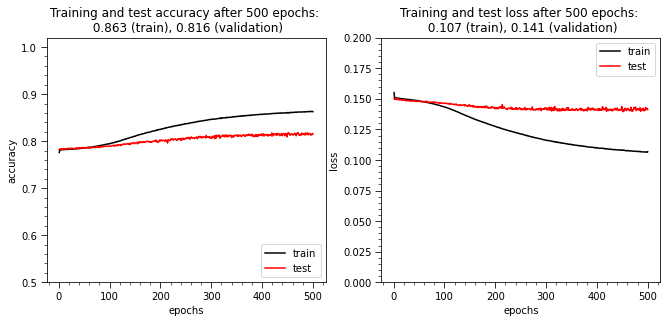

In [54]:
#plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,4.5))    

results_dict = test1_model_history.history
epochs = range(1,len(results_dict['accuracy'])+1)

#accuracy
acc_values = results_dict['accuracy']
val_acc_values = results_dict['val_accuracy']
    
axs[0].plot(epochs,acc_values,color='black',label='train',linewidth=1.5,linestyle='-')
axs[0].plot(epochs,val_acc_values,color='red',label='test',linewidth=1.5,linestyle='-')
axs[0].set_xlabel('epochs')
minorLocatorX = AutoMinorLocator()
axs[0].xaxis.set_minor_locator(minorLocatorX)
axs[0].set_ylabel('accuracy')
axs[0].set_ylim([0.5, 1.02])   
minorLocatorY = AutoMinorLocator()
axs[0].yaxis.set_minor_locator(minorLocatorY)
axs[0].tick_params(which='major', length=6)
axs[0].tick_params(which='minor', length=3, color='black')       
axs[0].legend(loc='lower right')
    
#loss
loss_values = results_dict['loss']
val_loss_values = results_dict['val_loss']
       
axs[1].plot(epochs,loss_values,color='black',label='train',linewidth=1.5,linestyle='-')
axs[1].plot(epochs,val_loss_values,color='red',label='test',linewidth=1.5,linestyle='-')
axs[1].set_xlabel('epochs')
minorLocatorX = AutoMinorLocator()
axs[1].xaxis.set_minor_locator(minorLocatorX)   
axs[1].set_ylabel('loss')
axs[1].set_ylim([0.0, 0.2])   
minorLocatorY = AutoMinorLocator()
axs[1].yaxis.set_minor_locator(minorLocatorY)
axs[1].tick_params(which='major', length=6)
axs[1].tick_params(which='minor', length=3, color='black')    
axs[1].legend(loc='upper right')

axs[0].set_title('Training and test accuracy after {} epochs: \n {:.3f} (train), {:.3f} (validation)'
                 .format(len(epochs),acc_values[-1],val_acc_values[-1]));

axs[1].set_title('Training and test loss after {} epochs: \n {:.3f} (train), {:.3f} (validation)'
                 .format(len(epochs),loss_values[-1],val_loss_values[-1]));
plt.savefig('plots_ann_new.png', dpi=100)

In [44]:
ypred2 =test1_model.predict(X_test)
#####
print('Traning and Testing on raw data, all features \n');
#### Model accuracy
# print("Accuracy:", metrics.accuracy_score(y_test, ypred2))

3613/3613 [==============================] - 3s 925us/step
Traning and Testing on raw data, all features 



In [45]:
np.shape(ypred2), np.shape(y_test)

((115600, 1), (115600,))

In [46]:
print("NEURAL NETWORK")
print("Accuracy:", metrics.accuracy_score(y_test, ypred2.round()))
print("F1:", metrics.f1_score(y_test, ypred2.round()))
print("Precision:", metrics.precision_score(y_test, ypred2.round()))


NEURAL NETWORK
Accuracy: 0.8130709342560554
F1: 0.8160012261475975
Precision: 0.8031915785238949


Confusion matrix, without normalization
[[46075 11741]
 [ 9868 47916]]


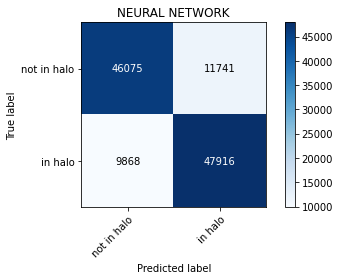

In [55]:
plot_confusion_matrix(y_test, ypred2.round(), classes=['not in halo', 'in halo'])
plt.title("NEURAL NETWORK")
plt.savefig("conf_matrix_ann_new.png", dpi=100)